# Remapping the `PISM` Grid to `MPIOM`
*Author:* Paul Gierz

In [1]:
# Notebook init
import geopy.distance
import progressbar
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from multiprocessing import Pool
import itertools
import math

%matplotlib notebook
%load_ext tikzmagic

In order to release the freshwater calculated by `PISM` into `MPIOM`, we must determine the *closest geographical ocean grid cell* relative to each *ice grid cell*. Since we know the longitude ($\varphi$) and latitude ($\theta$) of each cell on each grid, the problem translates to determining the minimum distance between two arbitrary ($\varphi, \theta$) coordinate pairs on a spherical grid. 

Some considerations:
1. The Earth isn't really a perfect sphere.
2. ...?
3. Probably, I should think of more potential mistakes

First, we must be able to determine the distance between two points on a sphere. This can be accomplished by project the spherical coordinates back into cartesian coordinates.

TODO: Rotate sphere a little...

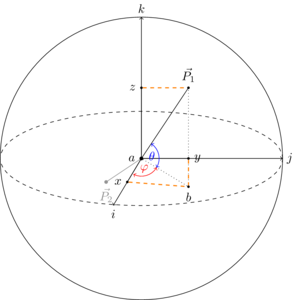

In [2]:
%%tikz -l angles,quotes -sc 2 -s 300,300
% Define radius
\def\r{2}

% Draw P1
\draw (0,0) node[circle,fill,inner sep=1,label=left:$a$] (orig) {} -- (\r/3,\r/2) node[circle,fill,inner sep=0.7,label=above:$\vec{P_{1}}$] (a) {};
\draw[dotted] (orig) -- (\r/3,-\r/5) node[circle,fill,inner sep=0.7,label=below:$b$] (phi) {} -- (a);

%Draw P2
\draw[gray] (orig) -- (-\r/4, -\r/6) node[circle,fill,inner sep=1,label=below:$\vec{P_{2}}$] (P2) {};

% Axes
\draw[->] (orig) -- ++(-\r/5,-\r/3) node[below] (x1) {$i$};
\draw[->] (orig) -- ++(\r,0) node[right] (x2) {$j$};
\draw[->] (orig) -- ++(0,\r) node[above] (x3) {$k$};

% Decomposition vector r onto axes i, j, and k
\draw (0,0) node[circle,fill,inner sep=1] (orig) {} -- (\r/3,0) node[circle,fill,inner sep=0.7,label=right:$y$] (y) {};
\draw (0,0) node[circle,fill,inner sep=1] (orig) {} -- (0,\r/2) node[circle,fill,inner sep=0.7,label=left:$z$] (z) {};
\draw (0,0) node[circle,fill,inner sep=1] (orig) {} -- (-\r/5/2,-\r/3/2) node[circle,fill,inner sep=0.7,label=left:$x$] (x) {};
\draw[dashed, orange, thick] (z) -- (a) (y) -- (phi) (x) -- (phi);

% Sphere (this is a perfect circle and an elispe, with radii r and r/3)
\draw (orig) circle (\r);
\draw[dashed] (orig) ellipse (\r{} and \r/3);


%Angles
\pic [draw=red,text=red,<->,"$\varphi$"] {angle = x1--orig--phi};
\pic [draw=blue,text=blue,<->,"$\theta$"] {angle = phi--orig--a};


The sphere above can serve as a useful guide for determining several distances. Given we know $\varphi$ and $\theta$, and the radius of the sphere (which is the radius of the Earth, $R$). We can determine some lengths:

\begin{align}
|ab| &= R\cos{\theta} \\
|ax| &= R\cos{\theta}\cos{\varphi} \\
|ay| &= R\cos{\theta}\sin{\varphi} \\
|az| &= R\sin{\theta}
\end{align}

Transforming the coordinates now alows us to put $\vec{P_1}=(x_1,y_1,z_1)$ and $\vec{P_2}=(x_2,y_2,z_2)$. If we were to cut the sphere into a plane, the linear distance between $\vec{P_1}$ and $\vec{P_2}$ is:

\begin{align}
|P_{1}P_{2}| = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2 + (z_1-z_2)^2  } = L
\end{align}

However, we want the distance $D$ along the arc of a circle, so we can also split the sphere into a circle containing $\vec{P_1}$ and $\vec{P_2}$:

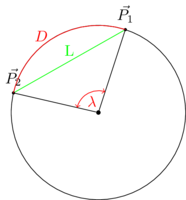

In [3]:
%%tikz -l angles,quotes,calc -sc 2 -s 200,200
% Define radius
\def\r{1}
\draw (0,0) node[circle,fill,inner sep=1,label=left:$$] (orig) {} -- ({cos(72)},{sin(72)}) node[circle,fill,inner sep=0.7,label=above:$\vec{P_{1}}$] (P1) {};
\draw (0,0) (orig) {} -- ({cos(167)},{sin(167)}) node[circle,fill,inner sep=0.7,label=above:$\vec{P_{2}}$] (P2) {};
\draw [green] (P1) --  node[above]{L} ++ (P2);
\draw (orig) circle (\r);
\pic [draw=red,text=red,<->,"$\lambda$"] {angle = P1--orig--P2};

\draw[red]({cos(72)},{sin(72)}) arc[radius = 1, start angle=72, end angle=131] node[above]{$D$} arc[radius = 1, start angle=131, delta angle=36];

$$
\newcommand{\x}[1]{R\cos{\theta}_{#1}\cos{\varphi}_{#1}}
\newcommand{\y}[1]{R\cos{\theta}_{#1}\sin{\varphi}_{#1}}
\newcommand{\z}[1]{R\sin{\theta}_{#1}}
$$       

\begin{align}
\sin{\left(\frac{\lambda}{2}\right)} &= \frac{L}{2R} \\
\lambda &= 2 \arcsin{\left(\frac{L}{2R}\right)} \\
0\leq &\lambda \leq 2\pi \\
D &= \lambda R = 2 R \arcsin{\left(\frac{L}{2R}\right)} \\
D&= 2 R \arcsin{\left(\frac{\sqrt{(\x1-\x2)^2 + (\y1-\y2)^2 + (\z1-\z2)^2  } }{2R}\right)} 
\end{align}

We now want to turn this into a python function:

In [4]:
# Turn the math into a function
def distance_between_to_lon_lat_points(lon_grid_1, lat_grid_1, lon_grid_2, lat_grid_2):
    R = 6371 * 1000.
    lon_grid_1, lat_grid_1 = math.radians(lon_grid_1), math.radians(lat_grid_1)
    lon_grid_2, lat_grid_2 = math.radians(lon_grid_2), math.radians(lat_grid_2)
    def x(phi, theta):
        return R * math.cos(theta) * math.cos(phi)
    def y(phi, theta):
        return R * math.cos(theta) * math.sin(phi)
    def z(theta):
        return R * math.sin(theta)
    root_term = (
                (x(lon_grid_1, lat_grid_1) - x(lon_grid_2, lat_grid_2))**2 +
                (y(lon_grid_1, lat_grid_1) - y(lon_grid_1, lat_grid_1))**2 +
                (z(lat_grid_1) - z(lat_grid_2)**2)
                )**0.5
    D = 2*R * math.asin(root_term/(2*R))
    
    return D

There is already a library for this, so I just practiced geometry and Tikz for an hour without needing to :-(

https://pypi.python.org/pypi/geopy

....boo! Ok, well we will use the geopy one then.

First we need to open the files, and look at the lon/lat grids in question:

In [5]:
# Open files and load data
ocean_map_file = xr.open_dataset("/Users/pgierz/Research/PalMod_Freshwater_Forcing/mapping_ocean.nc")
ice_map_file = xr.open_dataset("/Users/pgierz/Research/PalMod_Freshwater_Forcing/nhem_20km_xylatlon.nc")
ice_lon = ice_map_file["lon"].squeeze()
ice_lat = ice_map_file["lat"].squeeze()

ocean_lon = ocean_map_file["oces.lon"].squeeze()
ocean_lat = ocean_map_file["oces.lat"].squeeze()

In [6]:
# Plot Ocean lat/lon and ice lat/lon
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6))
ocean_lon.plot(ax=ax1), ocean_lat.plot(ax=ax2)
ice_lon.plot(ax=ax3), ice_lat.plot(ax=ax4)
f.tight_layout()

<IPython.core.display.Javascript object>

Ok, now I want to makes arrays with the `i` index of the nearest ocean grid from the ice grid, and the nearest `j` index of the ocean grid from the ice grid. Since we have this many total cells, and we need to compare against almost all of them, this is probably best done as a function that is then assigned to a multiprocessor pool.

In [7]:
600*600*220*256

20275200000

In [31]:
# Allocate Arrays
nearest_i_index_of_ocean_grid = np.zeros(ice_lon.shape)
nearest_j_index_of_ocean_grid = np.zeros(ice_lat.shape)
smallest_distances = np.zeros(ice_lat.shape)
distance = np.ones(ice_lat.shape)
distance *= 2*geopy.distance.EARTH_RADIUS

In [32]:
# Define a function to assign in a multiprocessor pool
def assign_index_to_arrays(params, test=False):
    ocean_index_i = params[0]
    ocean_index_j = params[1]
    ice_index_i = params[2]
    ice_index_j = params[3]
    if test: print(ocean_index_i, ocean_index_j, ice_index_i, ice_index_j)
    if not (np.isnan(ocean_lat[ocean_index_i, ocean_index_j].data) or \
            np.isnan(ocean_lon[ocean_index_i, ocean_index_j].data)):
        # Build the distance tuple:
        ocean_lat_lon = (ocean_lat[ocean_index_i, ocean_index_j].data, 
                         ocean_lon[ocean_index_i, ocean_index_j].data)
        ice_lat_lon = (ice_lat[ice_index_i, ice_index_j].data, 
                       ice_lon[ice_index_i, ice_index_j].data)
        current_distance = geopy.distance.GreatCircleDistance(ocean_lat_lon, ice_lat_lon).kilometers
        if test: print(current_distance)
        if current_distance < distance[ice_index_i, ice_index_j]:
            distance[ice_index_i, ice_index_j] = current_distance
            nearest_i_index_of_ocean_grid[ice_index_i, ice_index_j] = ocean_index_i
            nearest_j_index_of_ocean_grid[ice_index_i, ice_index_j] = ocean_index_j
            smallest_distances[ice_index_i, ice_index_j] = current_distance

In [34]:
# A test
np.isnan(ocean_lat[51, 2].data)
assign_index_to_arrays((51, 2, 7, 6), test=True)

51 2 7 6
6778.174389437446


In [10]:
# Load the pool
pool = Pool()

In [43]:
# Generate a test parameter list
paramlist = list(itertools.product(range(2),
                                   range(2),
                                   range(2),
                                   range(2)))

In [44]:
len(paramlist)

16

In [ ]:
# The following computation cell, which should launch a multi-processor pool to run this in parallel
# fails for reasons I don't undrestand.

pool.map(assign_index_to_arrays, paramlist)                                                   

Since the multi-process statement doesn't seem to work, I need to run this on one of the supercomputers on one of the login nodes. The script `map_grids.py` does this.